In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## read data

In [4]:
train = pd.read_csv('train.csv', encoding='mac-roman', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
address = pd.read_csv('addresses.csv', index_col=0)
latlon = pd.read_csv('latlons.csv', index_col=0)

C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## create some feature

In [5]:
address = address.merge(latlon, how='inner', left_on = 'address', right_index=True)
address = address[['lon','lat']]
train = train.merge(address, how='inner', left_index=True, right_index=True)
test = test.merge(address, how='inner', left_index=True, right_index=True)

In [6]:
train['ticket_issued_date'] = pd.to_datetime(train['ticket_issued_date'])
train['hearing_date'] = pd.to_datetime(train['hearing_date'])
train['delta_date'] = (train['hearing_date'] - train['ticket_issued_date']).dt.days

test['ticket_issued_date'] = pd.to_datetime(test['ticket_issued_date'])
test['hearing_date'] = pd.to_datetime(test['hearing_date'])
test['delta_date'] = (test['hearing_date'] - test['ticket_issued_date']).dt.days

In [7]:
droped_index = train[(train['compliance'].isnull()) | (train['country']!='USA')].index
train = train.drop(droped_index, axis=0)

In [8]:
test.shape

(61001, 29)

In [9]:
train = train[list(test.columns.values) + ['compliance']]

## 删除无用列

In [10]:
drop_col = ['non_us_str_code', 'violation_zip_code', 'grafitti_status',
            'ticket_issued_date','hearing_date','mailing_address_str_number','country']

In [11]:
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

## 处理缺失值

In [12]:
train[['delta_date','lon','lat','zip_code']] = train[['delta_date','lon','lat','zip_code']].fillna(0)
test[['delta_date','lon','lat','zip_code']] = test[['delta_date','lon','lat','zip_code']].fillna(0)

In [13]:
train[['violator_name','mailing_address_str_name','state']]=\
train[['violator_name','mailing_address_str_name','state']].fillna('N/A')
test[['violator_name','mailing_address_str_name','state','city']]=\
test[['violator_name','mailing_address_str_name','state','city']].fillna('N/A')

## 处理数据类型

In [15]:
Train = train.copy()
Test = test.copy()

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for item in Test.columns.values:
    if Test[item].dtype=='object':
        Test[item] = le.fit_transform(Test[item].astype('str'))
        Train[item] = le.fit_transform(Train[item].astype('str'))

## 查看特征重要度

In [17]:
from sklearn.ensemble import RandomForestRegressor
y = Train['compliance']
X = Train.drop('compliance', axis = 1)

rfr = RandomForestRegressor(max_depth = 20).fit(X, y)

feature_importance = rfr.feature_importances_
feature_names = X.columns.values

data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

<IPython.core.display.Javascript object>


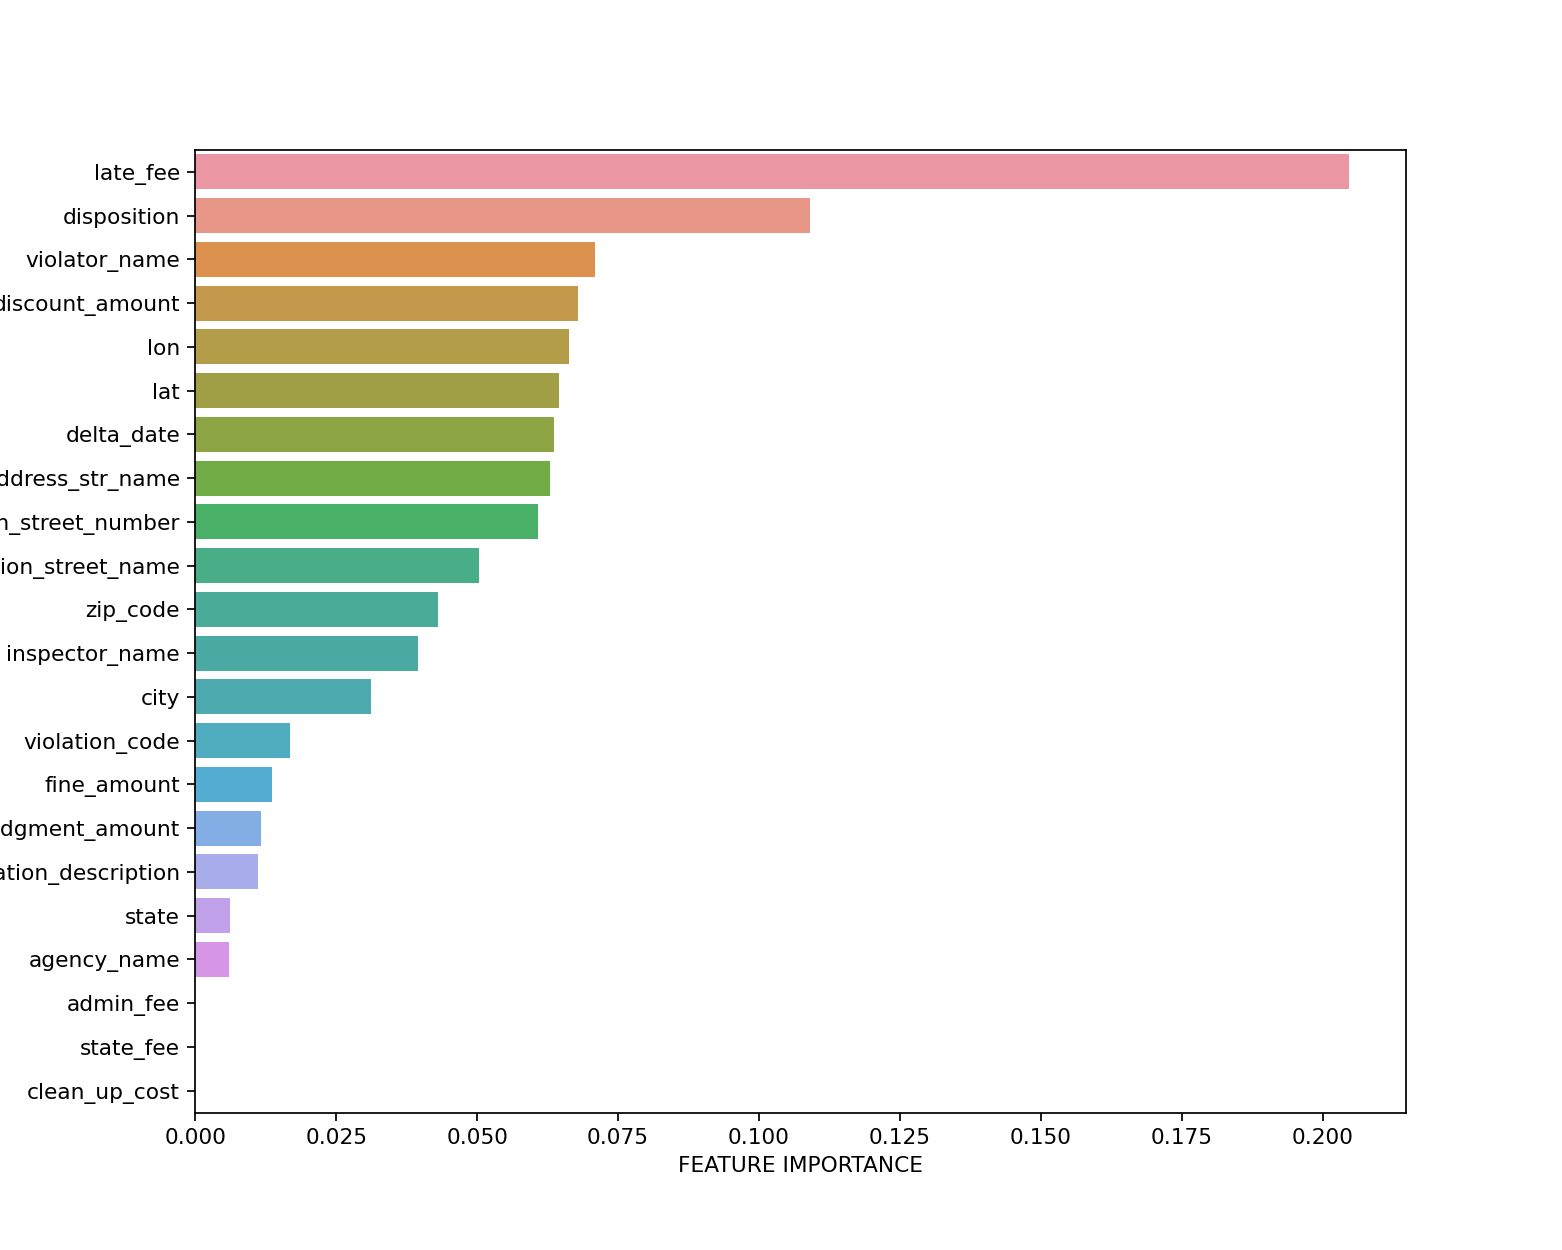

Text(0, 0.5, 'FEATURE NAMES')

In [52]:
import seaborn as sns
#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

## 使用前n个feature测试rocscore

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


In [55]:
for i in range(2, len(fi_df)-3):
    X = Train[fi_df['feature_names'][:i]]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    rf_regression = RandomForestRegressor(max_depth = 5).fit(X_train, y_train)
    y_predict = rf_regression.predict(X_test)
    print(i, roc_auc_score(y_test, y_predict))


2 0.7955569753042095
3 0.7850984962503067
4 0.800707831192023
5 0.799073786253898
6 0.7991460359253371
7 0.7943180461258093
8 0.7986093507913008
9 0.8057581132700603
10 0.8006194414277453
11 0.8009585211497644
12 0.8062999617170737
13 0.8005298091485173
14 0.8141687877408005
15 0.8055214934553506
16 0.8049409587626195
17 0.8056592025773758
18 0.8028859503176028


In [19]:
from sklearn.ensemble import GradientBoostingRegressor

In [65]:
X = Train[fi_df['feature_names'][:6]]
X_train, X_test, y_train, y_test = train_test_split(X, y)
rf_regression = GradientBoostingRegressor(max_depth = 5).fit(X_train, y_train)
y_predict = rf_regression.predict(X_test)
print(roc_auc_score(y_test, y_predict))

0.81835871483065


## 使用pca降维度

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = Train[fi_df['feature_names'][:14]]
X_normalized = StandardScaler().fit(X).transform(X)  

pca = PCA(n_components = 4).fit(X_normalized)

X_pca = pca.transform(X_normalized)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y)
rf_regression = GradientBoostingRegressor(max_depth = 5).fit(X_train, y_train)
y_predict = rf_regression.predict(X_test)
print(roc_auc_score(y_test, y_predict))

0.5422554776304482


In [22]:
rf_regression_for_test = GradientBoostingRegressor(max_depth = 5).fit(X_pca, y)

In [23]:

Test_cleaned = Test[fi_df['feature_names'][:14]]
Test_normalized = StandardScaler().fit(Test_cleaned).transform(Test_cleaned)
pca = PCA(n_components = 4).fit(Test_normalized)
Test_pca = pca.transform(Test_normalized)

result = rf_regression.predict(Test_pca)

In [24]:
pd.Series(result, Test.index)

ticket_id
284932    0.058711
285362    0.179717
285361    0.045471
285338    0.048578
285346    0.033938
            ...   
376496    0.053903
376497    0.053903
376499    0.254872
376500    0.121996
369851    0.039479
Length: 61001, dtype: float64